# State Farm Distracted Driver Detection

https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview

c0 : safe driving


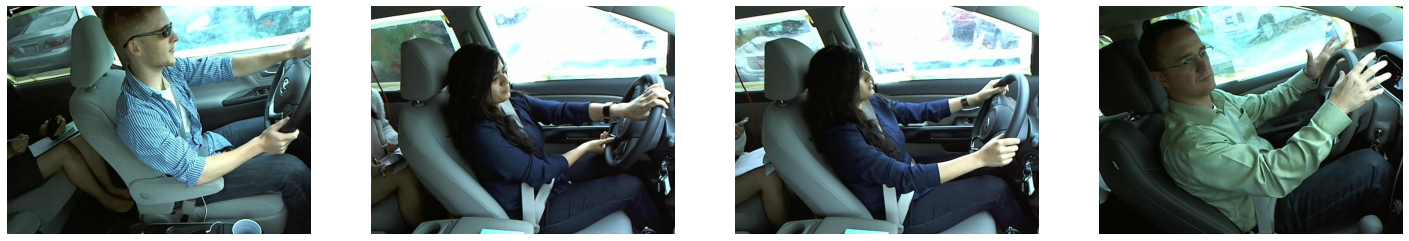

c1 : texting - right


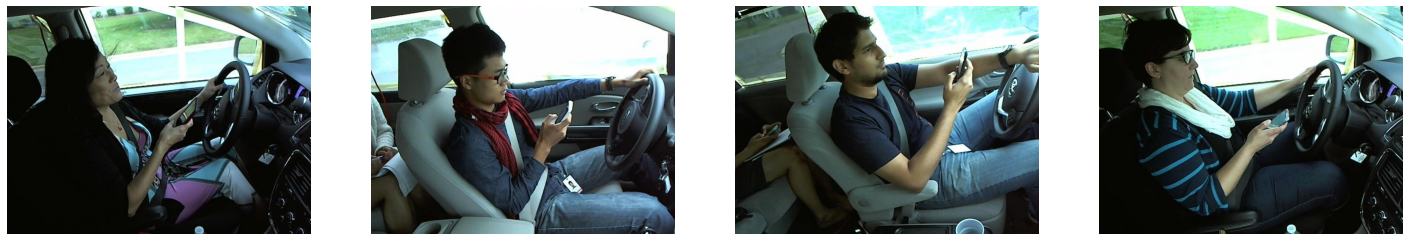

c2 : talking on the phone - right


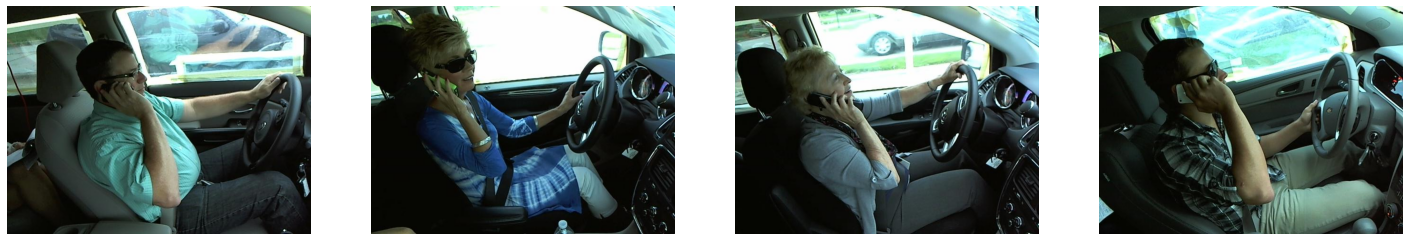

c3 : texting - left


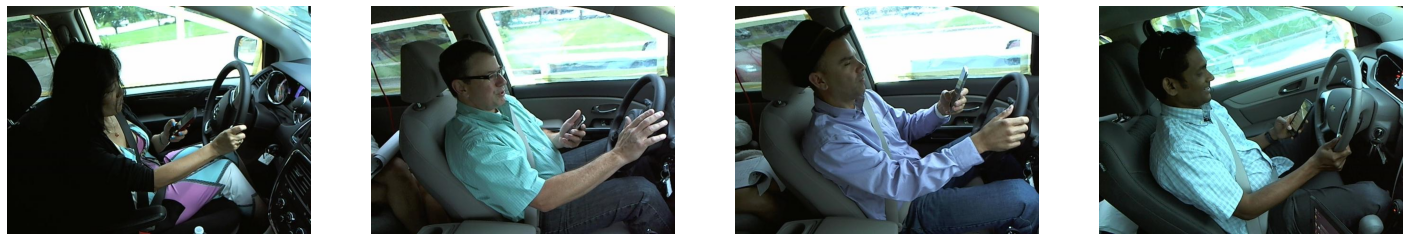

c4 : talking on the phone - left


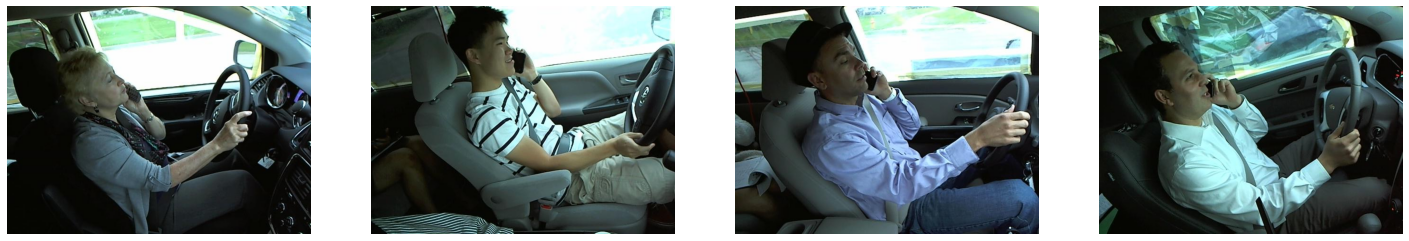

c5 : operating the radio


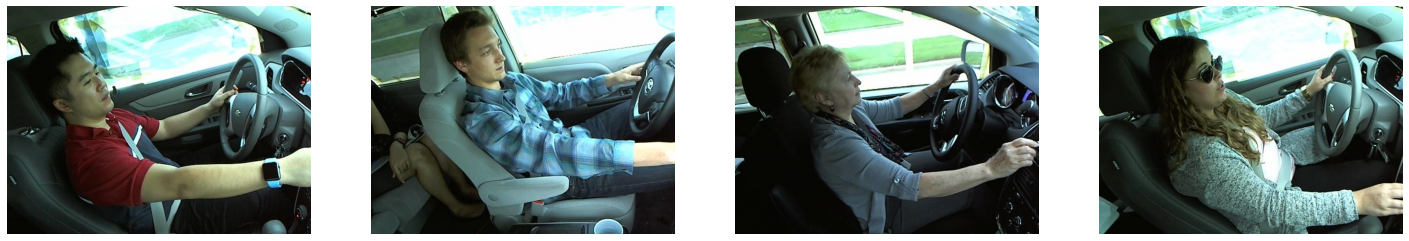

c6 : drinking


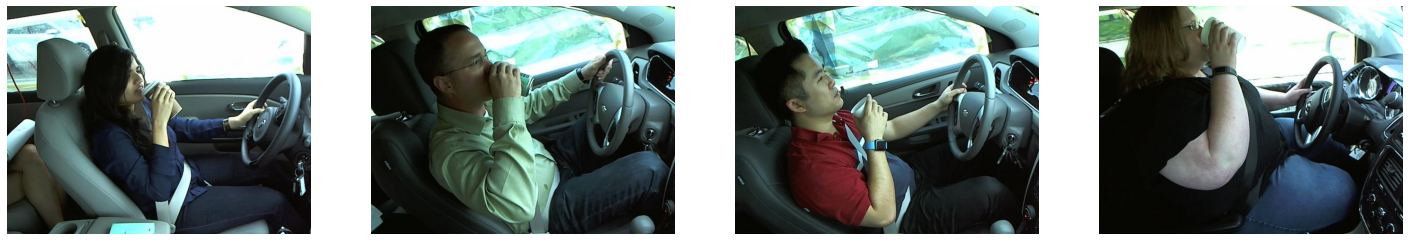

c7 : reacing behind


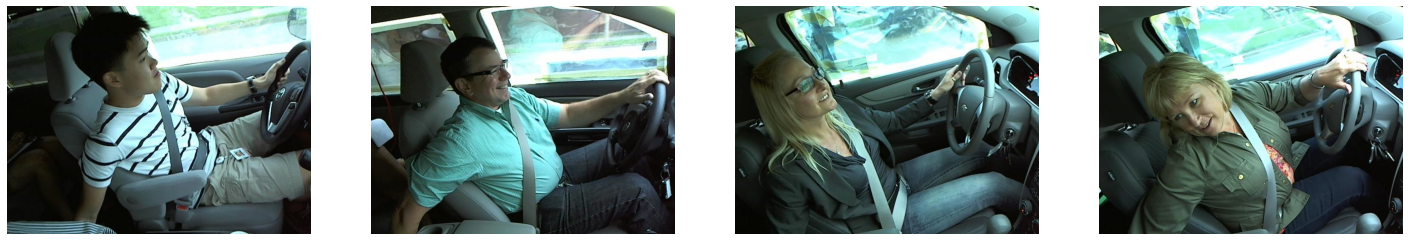

c8 : hair and makeup


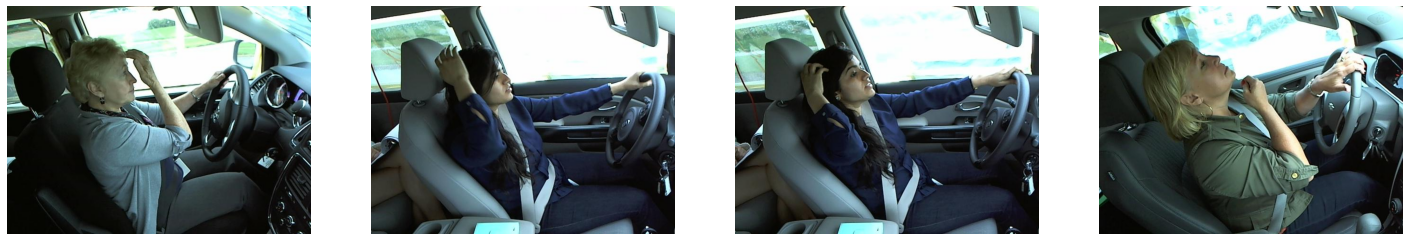

c9 : talking to passenger


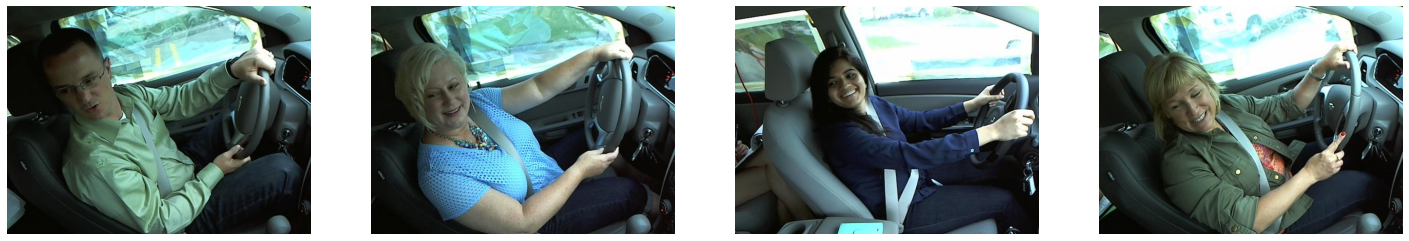

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

train_data_dir = '.\\datasets\\state_farm_distracted_driver_detection\\imgs\\train'
test_data_dir = '.\\datasets\\state_farm_distracted_driver_detection\\imgs\\test'

labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
col_to_kor = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reacing behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}
for label in labels:
    f, ax = plt.subplots(figsize=(25, 5))
    files = glob(train_data_dir + '\\{}\\*.jpg'.format(label))
    for x in range(4):
        plt.subplot(1, 4, x+1)
        im = Image.open(files[x])
        im_list = np.asarray(im)
        plt.imshow(im_list)
        #plt.title('{} : {}'.format(label, col_to_kor[label]))
        plt.axis('off')
    print('{} : {}'.format(label, col_to_kor[label]))
    plt.show()

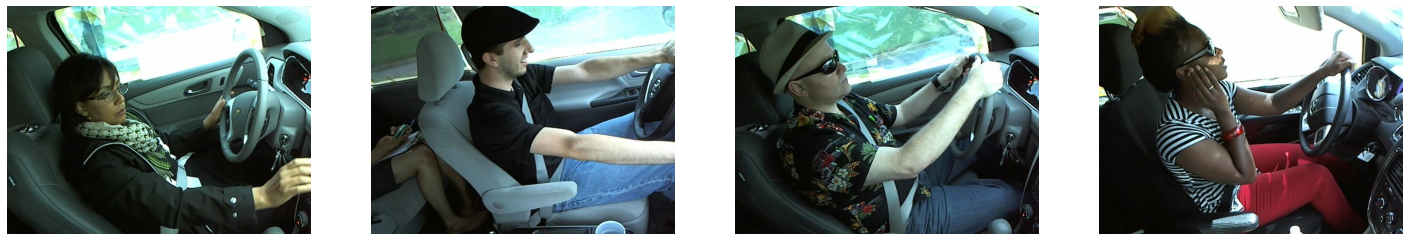

In [2]:
f, ax = plt.subplots(figsize=(25, 10))
files = glob(test_data_dir + '\\*.jpg')
    
for x in range(4):
    plt.subplot(1, 4, x+1)
    im = Image.open(files[x])
    im_list = np.asarray(im)
    plt.imshow(im_list)
    plt.axis('off')

In [3]:
import shutil

fc_size = 2048
n_class = 10
seed = 10
n_splits = 5
test_nfolds = 3
img_row_size, img_col_size = 224, 224
#train_path = '../input/train'
#test_path = '../input/test'
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

temp_train_fold = '.\\datasets\\state_farm_distracted_driver_detection\\train'
temp_valid_fold = '.\\datasets\\state_farm_distracted_driver_detection\\valid'
temp_test_fold = '.\\datasets\\state_farm_distracted_driver_detection\\test'
cache = '.\\datasets\\state_farm_distracted_driver_detection\\cache'
subm = '.\\datasets\\state_farm_distracted_driver_detection\\subm'

def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
for path in [temp_train_fold, temp_valid_fold, temp_test_fold, cache, subm]:
    _clear_dir(path)

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def get_model():
    base_model = VGG16(include_top=False, weights=None, input_shape=(img_row_size, img_col_size,3))
    
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.summary()

    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
drivers = pd.read_csv('.\\datasets\\state_farm_distracted_driver_detection\\driver_imgs_list.csv')
img_to_driver = {}
uniq_drivers = []

for i, row in drivers.iterrows():
    label_n_driver = {}
    label_n_driver['label'] = row['classname']
    label_n_driver['driver'] = row['subject']
    img_to_driver[row['img']] = label_n_driver

    if row['subject'] not in uniq_drivers:
        uniq_drivers.append(row['subject'])

In [6]:
import subprocess

def _generate_temp_folder(root_path):
    _clear_dir(root_path)
    for i in range(n_class):
        os.mkdir('{}/c{}'.format(root_path, i))

def generate_driver_based_split(img_to_driver, train_drivers):
    # イメージジェネレーターのために一時的に訓練／検証フォルダーを生成します。
    _generate_temp_folder(temp_train_fold)
    _generate_temp_folder(temp_valid_fold)

    # データを一時的に訓練／検証フォルダーへランダムにコピーします。
    train_samples = 0
    valid_samples = 0
    
    for img_path in img_to_driver.keys():
        cmd = 'copy {}\\{}\\{} {}\\{}\\{} > nul'
        label = img_to_driver[img_path]['label']
        if not os.path.exists('{}\\{}\\{}'.format(train_data_dir, label, img_path)):
            continue
        if img_to_driver[img_path]['driver'] in train_drivers:
            cmd = cmd.format(train_data_dir, label, img_path, temp_train_fold, label, img_path)
            train_samples += 1
        else:
            cmd = cmd.format(train_data_dir, label, img_path, temp_valid_fold, label, img_path)
            valid_samples += 1
        # イメージの複製
        subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)

    # 訓練／検証データの個数を出力します。
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples

In [7]:
def crop_center(img, cropx, cropy):
    # イメージの中間をCropする関数を定義します。
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [8]:
def preprocess(image):
    # イメージデータを0~1の値で調整します。
    image /= 255.

    # イメージを最大-20~20度回転させます。
    rotate_angle = np.random.randint(40) - 20
    image = rotate(image, rotate_angle)

    # イメージを最大 -30~30pixel 移動します。
    rows, cols, _ = image.shape
    width_translate = np.random.randint(60) - 30
    height_translate = np.random.randint(60) - 30
    M = np.float32([[1,0,width_translate],[0,1,height_translate]])
    image = cv2.warpAffine(image,M,(cols,rows))    

    # イメージを最大 0.8~1.0 ズームインします。
    width_zoom = int(img_row_size * (0.8 + 0.2 * (1 - np.random.random())))
    height_zoom = int(img_col_size * (0.8 + 0.2 * (1 - np.random.random())))
    final_image = np.zeros((height_zoom, width_zoom, 3))
    final_image[:,:,0] = crop_center(image[:,:,0], width_zoom, height_zoom)
    final_image[:,:,1] = crop_center(image[:,:,1], width_zoom, height_zoom)
    final_image[:,:,2] = crop_center(image[:,:,2], width_zoom, height_zoom)

    # (224, 224)の大きさでイメージを再調整します。
    image = cv2.resize(final_image, (img_row_size, img_col_size))
    return image

In [9]:
_generate_temp_folder(temp_test_fold+'\\test')
cmd = 'xcopy /e {} {} > nul'
cmd = cmd.format(test_data_dir, temp_test_fold+'\\test')
subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)

0

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

datagen = ImageDataGenerator()


test_generator = datagen.flow_from_directory(
        temp_test_fold,
        target_size=(img_row_size, img_col_size),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

test_id = [os.path.basename(fl) for fl in glob(temp_test_fold+'\\test' + '\\*.jpg')]

Found 79726 images belonging to 1 classes.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

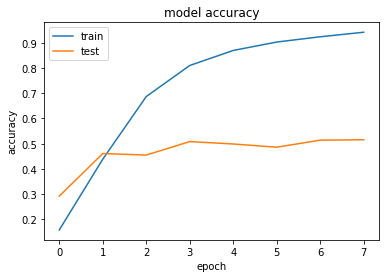

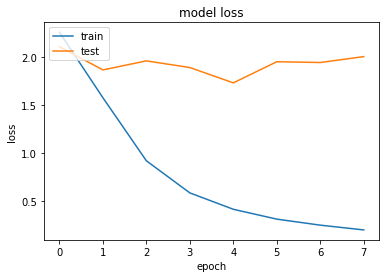

 2492/79726 [..............................] - 364s 146ms/step
go next kf
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
______________________________________________

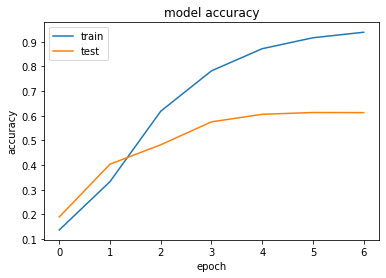

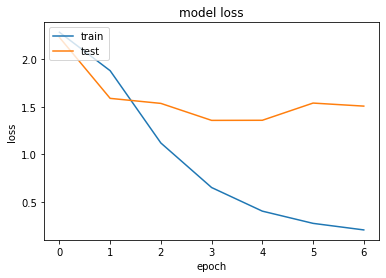

 2492/79726 [..............................] - 360s 144ms/step
go next kf
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
______________________________________________

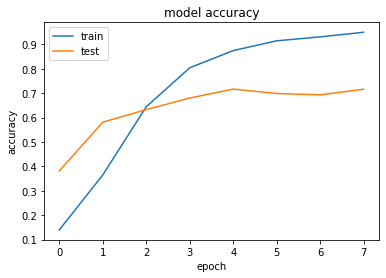

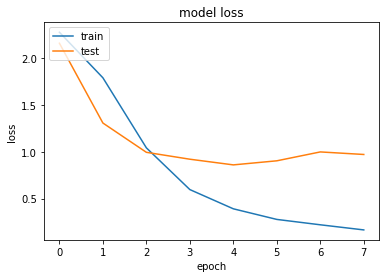

 2492/79726 [..............................] - 355s 142ms/step
go next kf
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
______________________________________________

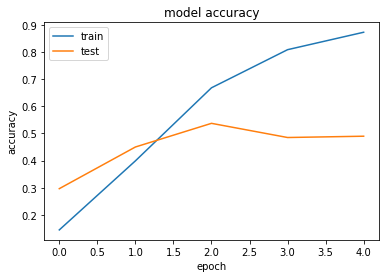

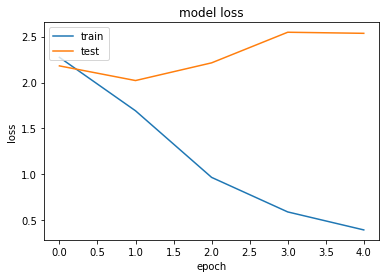

 2492/79726 [..............................] - 355s 142ms/step
go next kf
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              51382272  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
______________________________________________

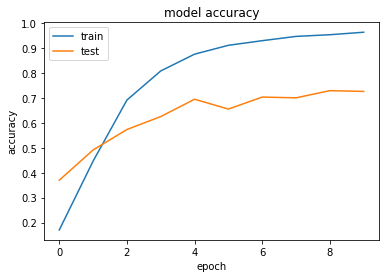

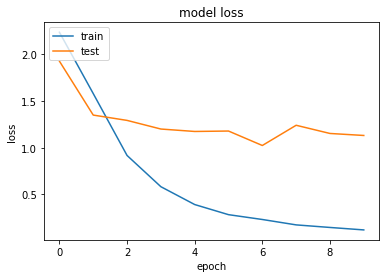

 2492/79726 [..............................] - 355s 142ms/step
go next kf


In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

#print(uniq_drivers)
#print(len(uniq_drivers))
kf = KFold(n_splits=n_splits, shuffle=True, random_state=20)
train_drivers_ = 0
valid_drivers_ = 0
fold_ = 0
train_samples_ = 0
valid_samples_ = 0

for fold, (train_drivers, valid_drivers) in enumerate(kf.split(uniq_drivers)):
    
    train_drivers_ = train_drivers
    valid_drivers_ = valid_drivers
    fold_ = fold
    
    model = get_model()
    
    train_drivers = [uniq_drivers[j] for j in train_drivers]
    train_samples, valid_samples = generate_driver_based_split(img_to_driver, train_drivers)
    
    train_samples_ = train_samples
    valid_samples_ = valid_samples

    '''
    train_drivers = train_drivers_
    valid_drivers = valid_drivers_
    train_samples = train_samples_
    valid_samples = valid_samples_
    '''
    
    print(train_drivers, valid_drivers)
    train_generator = datagen.flow_from_directory(
            directory=temp_train_fold,
            target_size=(img_row_size, img_col_size),
            batch_size=batch_size,
            class_mode='categorical',
            seed=seed)
    valid_generator = datagen.flow_from_directory(
            directory=temp_valid_fold,
            target_size=(img_row_size, img_col_size),
            batch_size=batch_size,
            class_mode='categorical',
            seed=seed)
    
    weight_path = cache + '\\weight.fold_{}.h5'.format(fold)
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
            ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]
    training = model.fit(
            train_generator,
            steps_per_epoch=train_samples/batch_size,
            epochs=128,
            validation_data=valid_generator,
            validation_steps=valid_samples/batch_size,
            shuffle=True,
            callbacks=callbacks,
            verbose=1)

    #正答率
    plt.plot(training.history['accuracy'])
    plt.plot(training.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #loss
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    
    for j in range(test_nfolds):
        preds = model.predict(
                test_generator,
                steps=len(test_id),
                #steps_per_epoch=len(test_id)/batch_size,
                verbose=1)

        if j == 0:
            result = pd.DataFrame(preds, columns=labels)
        else:
            result += pd.DataFrame(preds, columns=labels)
            
    result /= test_nfolds
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    sub_file = subm + '\\f{}.csv'.format(fold)
    result.to_csv(sub_file, index=False)
    
    print('go next kf')

In [14]:
ensemble = 0
for fold in range(n_splits):
    ensemble += pd.read_csv(subm + '\\f{}.csv'.format(fold), index_col=-1).values * 1. / n_splits
ensemble = pd.DataFrame(ensemble, columns=labels)
ensemble.loc[:, 'img'] = pd.Series(test_id, index=ensemble.index)
sub_file = subm + '\\ens.csv'
ensemble.to_csv(sub_file, index=False)